In [3]:
!pip install networkx
!pip install matplotlib
!pip install tqdm

In [13]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby
import time

In [5]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

builtin_time = []
my_time = []

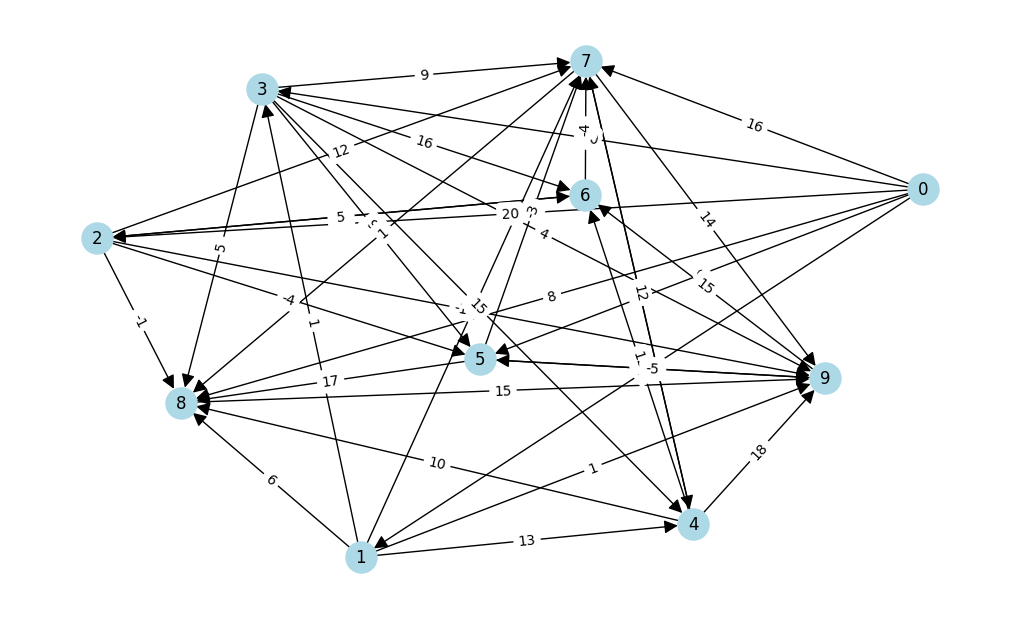

In [6]:
G = gnp_random_connected_graph(10, 0.7, True, True)

In [16]:
from networkx.algorithms import floyd_warshall_predecessor_and_distance
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries

start = time.perf_counter()
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")
end = time.perf_counter()
builtin_time.append(end - start)

Distances with 0 source: {0: 0, 2: 20, 1: 8, 3: 0, 5: -1, 7: -4, 8: -3, 4: 8, 6: 16, 9: 4}
Distances with 1 source: {1: 0, 8: -6, 3: 1, 4: 5, 7: -7, 9: 1, 0: inf, 2: 21, 5: -4, 6: 16}
Distances with 2 source: {2: 0, 5: -6, 6: 14, 7: -9, 8: -8, 9: -1, 0: inf, 1: inf, 3: inf, 4: 3}
Distances with 3 source: {3: 0, 4: 8, 5: -1, 6: 16, 7: -4, 8: -3, 9: 4, 0: inf, 1: inf, 2: 21}
Distances with 4 source: {4: 0, 6: 12, 7: 8, 8: 9, 9: 16, 0: inf, 1: inf, 2: 17, 3: inf, 5: 11}
Distances with 5 source: {5: 0, 7: -3, 8: -2, 9: 11, 0: inf, 1: inf, 2: 26, 3: inf, 4: 9, 6: 21}
Distances with 6 source: {6: 0, 2: 5, 7: -4, 0: inf, 1: inf, 3: inf, 4: 8, 5: -1, 8: -3, 9: 4}
Distances with 7 source: {7: 0, 4: 12, 8: 1, 9: 14, 0: inf, 1: inf, 2: 29, 3: inf, 5: 9, 6: 24}
Distances with 8 source: {8: 0, 9: 15, 0: inf, 1: inf, 2: 35, 3: inf, 4: 19, 5: 10, 6: 30, 7: 7}
Distances with 9 source: {9: 0, 5: -5, 6: 15, 0: inf, 1: inf, 2: 20, 3: inf, 4: 4, 7: -8, 8: -7}
0.001618499998585321


In [8]:
inf = float('inf')

def generate_mtrx(graph:nx.DiGraph)->list:
    '''
    This function generates a matrix of weights for given weighted graph
    '''
    weighted_mtrx = []
    for node_ in graph.nodes:
        tmp_lst = []
        for neighbor in graph.nodes:
            if neighbor == node_:
                tmp_lst.append(0)
            else:
                try:
                    tmp_lst.append(graph[node_][neighbor]['weight'])
                except KeyError:
                    tmp_lst.append(inf)
        weighted_mtrx.append(tmp_lst.copy())
    return weighted_mtrx

def floyd_warshall_mtrx(mtrx:list)->list:
    '''
    This function does floy_warshall algorythm using matrix of weights given
    '''
    for node_, line in enumerate(mtrx):
        for y, x in enumerate(mtrx):
            if y == node_ or x[node_] == inf:
                continue
            tmp_lst = []
            for ind, w in enumerate(x):
                if ind == y:
                    if (min(x[node_] + line[ind], w)) < 0:
                        return 'Negative cycle detected'
                tmp_lst.append((min(x[node_] + line[ind], w)))
            mtrx[y] = tmp_lst
    return mtrx

def from_lst_dct(mtrx:list)->dict:
    '''
    This function turns our result from list of lists to a dict
    '''
    if isinstance(mtrx, str):
        return mtrx
    res = {}
    for source, dests in enumerate(mtrx):
        weights_dct = {}
        for dest, weight in enumerate(dests):
            weights_dct[dest] = weight
        res[source] = weights_dct
    return res

def floyd_warshall_alg(graph:nx.DiGraph)->dict:
    '''
    This function does floyd_warshall_alg with all the steps inside it
    '''
    return from_lst_dct(floyd_warshall_mtrx(generate_mtrx(graph)))

In [17]:
start = time.perf_counter()
res = floyd_warshall_alg(G)
try:
    for k, v in res.items():
            print(f"Distances with {k} source:", dict(v))
except:
    print(res)
end = time.perf_counter()
my_time.append(end-start)

Distances with 0 source: {0: 0, 1: 8, 2: 20, 3: 0, 4: 8, 5: -1, 6: 16, 7: -4, 8: -3, 9: 4}
Distances with 1 source: {0: inf, 1: 0, 2: 21, 3: 1, 4: 5, 5: -4, 6: 16, 7: -7, 8: -6, 9: 1}
Distances with 2 source: {0: inf, 1: inf, 2: 0, 3: inf, 4: 3, 5: -6, 6: 14, 7: -9, 8: -8, 9: -1}
Distances with 3 source: {0: inf, 1: inf, 2: 21, 3: 0, 4: 8, 5: -1, 6: 16, 7: -4, 8: -3, 9: 4}
Distances with 4 source: {0: inf, 1: inf, 2: 17, 3: inf, 4: 0, 5: 11, 6: 12, 7: 8, 8: 9, 9: 16}
Distances with 5 source: {0: inf, 1: inf, 2: 26, 3: inf, 4: 9, 5: 0, 6: 21, 7: -3, 8: -2, 9: 11}
Distances with 6 source: {0: inf, 1: inf, 2: 5, 3: inf, 4: 8, 5: -1, 6: 0, 7: -4, 8: -3, 9: 4}
Distances with 7 source: {0: inf, 1: inf, 2: 29, 3: inf, 4: 12, 5: 9, 6: 24, 7: 0, 8: 1, 9: 14}
Distances with 8 source: {0: inf, 1: inf, 2: 35, 3: inf, 4: 19, 5: 10, 6: 30, 7: 7, 8: 0, 9: 15}
Distances with 9 source: {0: inf, 1: inf, 2: 20, 3: inf, 4: 4, 5: -5, 6: 15, 7: -8, 8: -7, 9: 0}
0.0020437000021047425


In [10]:
print(res == dist)

True


In [ ]:
# plot for builtin alg
nodes_amount = [5, 10, 15, 20, 30, 40, 50, 80, 100, 150]
xpoints = np.array(nodes_amount)
ypoints = np.array(builtin_time)

plt.plot(xpoints, ypoints)
plt.show()